In [ ]:
#The purpose of this code is to create a base portfolio calcualtion module that:
#1) Calculates portfolio return and standard deviation through a standard function
#2) Performs a monte carlo analysis using random return values in a normal distribution given the historical portfolio risk/return profile
#3) Plot the final results

#This will be enhanced in future versions to identify optimal investments and weights

import pandas as pd
import yfinance as yf
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta

#set some initial variables
s = ['SCHO','SCHG','SCHV','SCHA']   #portfolio tickers
w = [.3,.3,.2,.2]                   #portfolio weights

sb = ['SPY','SCHO']                 #benchmark tickers
wb = [.7,.3]                        #benchmark weights

lookback = 5

mc_y = 30      #how many years should the monte carlo analysis go for
mc_p = 50000   #how much money should the account start with for the monte carlo analysis
mc_c = 100001  #how many times should we run this monte carlo analysis. By ending in 1, it ensures we can grab a clean median value

#calculate the start date based on the lookback period
startDt = date.today() - relativedelta(years=lookback)

#print this just to show us what our starting period is
print("starting date = " + str(startDt))


starting date = 2020-04-29


In [47]:
#The purpose of this function is to encapsulate the calculation for stock returns so as assumptions are toggled
#they can be run through the same method
#duration is expected to be in years

def returnCalc(startPrice, endPrice, startDate, endDate):

    #calculate the relative delta
    rdelta = relativedelta(endDate, startDate)

    #calculate the full annualized duration of the return period
    duration = rdelta.years + rdelta.months/12 + rdelta.days/365
    
    #return the percent change with the annualized compounding
    return ((endPrice / startPrice) ** (1/ duration)) - 1

In [48]:
#Create a function that returns various portfolio variables based on a set of ticker symbols, weights, and a start date

def PortfolioCalc(Tickers, Weights, startDate):

    #create some variables we need
    r = []   #create an empty list to hold the total return data
    pr = 0   #create a variable to hold the portfolio calculation value
    cnt = 0  #create a counter variable

    #loop through the input ticker symbols
    for i in Tickers:

        #Set the ticker we are looking at
        stock = yf.Ticker(i)
        
        #pull the price history as of the designated start date
        prices = stock.history(start=startDate).reset_index()[['Date','Close']]

        #if it's the first pass through the loop set the final dataframe equal to the one we are pulling now
        if i == Tickers[0]:
            df_s = prices

        #every other iteration join it together on the date
        else:
            df_s = df_s.merge(prices,how='left',left_on='Date',right_on='Date')

        #calculate the total return over this period
        ret = returnCalc(df_s.loc[0,['Close']].iloc[0], df_s.loc[df_s.shape[0]-1,['Close']].iloc[0], df_s.loc[0,['Date']].iloc[0], df_s.loc[df_s.shape[0]-1,['Date']].iloc[0])

        #append the return value to the return list so we can report all of them individually
        r.append(ret)

        #add the next set of returns to the portfolio return value
        pr = pr + ret * Weights[cnt]

        #rename the column name to the ticker symbol
        df_s = df_s.rename(columns={'Close': i})

        #add one to the counter
        cnt += 1

    #create a new dataframe so we can preserve the original price data pulled earlier
    df_p = df_s.copy()

    #Loop through all the columns in the dataframe
    for i in df_p.columns:

        #Don't do this for the Date column
        if i != 'Date':

            #convert the price to the percent change between each day
            df_p[i] = df_p[i].pct_change()

    #fill in na's with 0's, this should only happen for the first row
    df_p = df_p.fillna(0)

    #Last step - get the standard deviation of the portfolio

    #this gets the covariance matrix of the prices dataframe, dropping the "Date" column
    cov = df_p.drop(columns=['Date']).cov()
    


    #The standard deviation is calculated as square root of the portfolio weights * covariance matrix * portfolio weights
    sd = math.sqrt(Weights @ cov @ Weights)

    #return the prices dataframe, list of returns, portfolio return value, and portfolio standard deviation
    return(df_s, r, pr, sd)



In [49]:
#This is a monte carlo analysis, we will get a random path of portfolio returns based on the portfolio's risk/return profile
def MonteCarlo(num_y, num_i, open_bal, ret, sd):

  ls_mc = []  #create an empty list to hold the results

  #loop through the number of iterations that have been designated
  for i in range(0,num_i):

    cnt = 0     #create a counter variable

    #get random return numbers leveraging a normal distribution framework
    r_rand = np.random.normal(loc=ret, scale=sd, size=num_y) # mean, standard deviation and number of samples

    #set the initial balance to the starting variable
    bal = open_bal

    #loop through the generated return values
    for x in r_rand:
        
        #increment the counter variable
        cnt += 1

        #adjust the balance for the new year's return
        bal = round(bal * (1+x),2)

        #create a list with the various monte carlo results
        ls_mc.append({'run': i + 1,
                      'year': cnt,
                      'return': x,
                      'close_bal': bal})

  #convert the final data set to a data frame
  return(pd.DataFrame.from_records(ls_mc))


In [50]:
#this section gathers the relevant portfolio information and runs the monte carlo analysis for our custom portfolio

#get all the important portfolilo data from our PortfolioCalc function
df_prices, ret, ret_p, stdev_p = PortfolioCalc(s,w,startDt)

#Gather the Monte Carlo data set result
df_mc = MonteCarlo(mc_y, mc_c, mc_p, ret_p, stdev_p)

#Create a pivot of the monte carlo analysis so there is a row per year and a column per run
df_mc_p = df_mc.pivot(index = 'year', columns = 'run',values = 'close_bal').reset_index()



In [51]:
#this section gathers the relevant portfolio information and runs the monte carlo analysis for our benchmark portfolio

#get all the important portfolilo data from our PortfolioCalc function
df_prices_b, ret_b, ret_pb, stdev_pb = PortfolioCalc(sb,wb,startDt)

#Gather the Monte Carlo data set result
df_mc_b = MonteCarlo(mc_y, mc_c, mc_p, ret_pb, stdev_pb)

#Create a pivot of the monte carlo analysis so there is a row per year and a column per run
df_mc_pb = df_mc_b.pivot(index = 'year', columns = 'run',values = 'close_bal').reset_index()

In [52]:
#the purpose of this function is to find the column in a dataframe a value exists so we can pull the whole column
def df_find_col(val,df):
    t = df.eq(val).any() #find the value in the dataframe values
    return(t[t].index[0])  #return the column it's in

In [53]:
#capture some variables to get ready to plot the results

#find the column that resulted int he highest value
mc_max = df_mc_p.drop(columns=['year']).iloc[-1].max()
mc_max_col = df_find_col(mc_max, df_mc_p)

#find the column that resulted in the lowest value
mc_min = df_mc_p.drop(columns=['year']).iloc[-1].min()
mc_min_col = df_find_col(mc_min, df_mc_p)

#find the column that resulted in the median value
mc_med = df_mc_p.drop(columns=['year']).iloc[-1].median()
mc_med_col = df_find_col(mc_med, df_mc_p)

#find the column that resulted in the median value
mc_med_b = df_mc_pb.drop(columns=['year']).iloc[-1].median()
mc_med_col_b = df_find_col(mc_med_b, df_mc_pb)


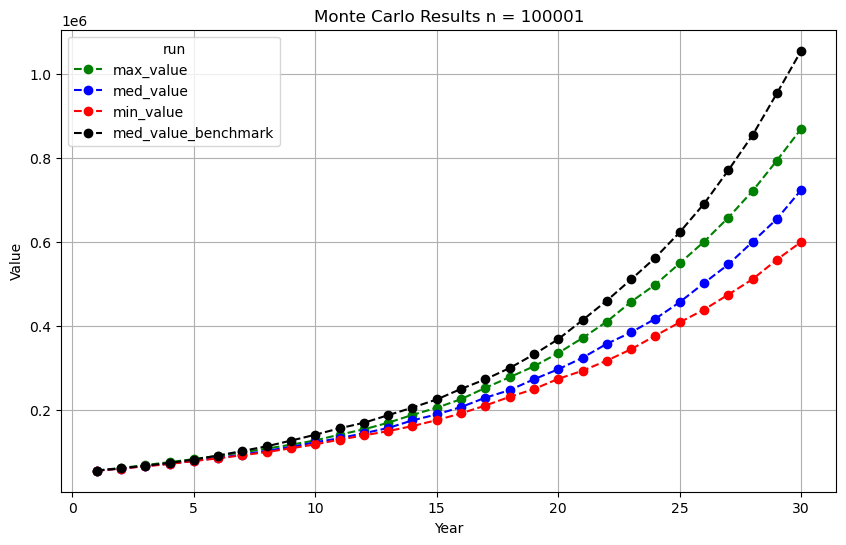

In [54]:
#create a dataframe with just the columns we identified above plus the date column and plot the result

#set a copy of the dataframe so we can create one just for our chart that only has a few columns
df_mc_p_c = df_mc_p.copy()
df_mc_p_c_b = df_mc_pb.copy()

#limit the columns to just the ones we identified above
df_mc_p_c = df_mc_p_c.iloc[:,[0,mc_max_col,mc_min_col,mc_med_col]]

#rename columns so we know what they are, using inplace=True means we don't need to set this to a different variable
df_mc_p_c.rename(columns={mc_max_col: 'max_value', mc_min_col: 'min_value', mc_med_col: 'med_value'}, inplace=True)

#also get the median column for the benchmark
df_mc_p_c_b = df_mc_p_c_b.iloc[:,[0,mc_med_col_b]]
df_mc_p_c_b.rename(columns={mc_med_col_b: 'med_value_benchmark'}, inplace=True)

#merge in the median benchmark value
df_mc_p_c = df_mc_p_c.merge(df_mc_p_c_b, how='left', left_on='year', right_on='year')

# Customizing the plot
df_mc_p_c.plot.line(
    x='year',
    y= ['max_value','med_value','min_value','med_value_benchmark'],
    title='Monte Carlo Results n = ' + str(mc_c),
    xlabel='Year',
    ylabel='Value',
    figsize=(10, 6),
    color=['green', 'blue', 'red','black'],
    linestyle='--',
    marker='o',
    grid=True
)

plt.show()

In [55]:
#Conclusion:
#Given a portfolio of 70/30 S&P 500 and Bond ETF, the median benchmark year outperforms a portfolio with a mix of bond ETF,
#large cap growth, large cap value, and small cap ETF's. Using this base code we can tweak the investments and weights until we hit
#an optimal mix that both hits return objectives and acheives a client's risk profile. 

#Further enhancements will be made to this over time

